In [3]:
import numpy as np
import scipy.sparse
import scipy.signal

# Poission Blending
Human eyes are good at detecting edges. When it comes to image blending, these edges caused by abrupt gradient changes become noticable seams that make people feel the blended image is not real. To overcome this, Poission blending tries to match the gradient of two images smoothly.

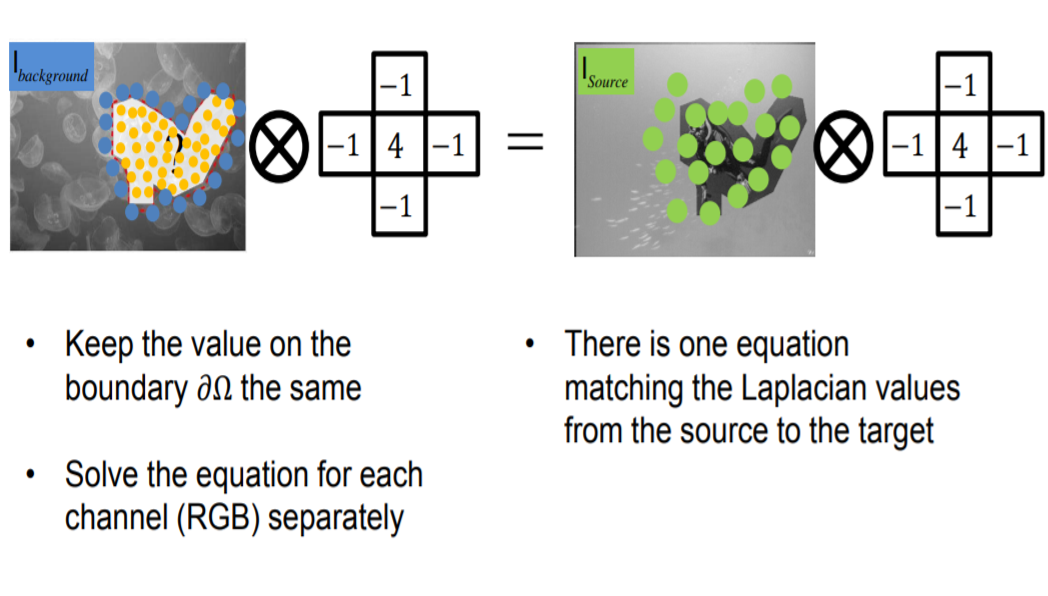


To do this, Possion blending method reconsturcts pixels in the blending area by making the gradient of the reconstructed area(area filled with yellow dots) close to the gradient of the source image while keeping boundary pixels(blue dots) unchanged from the target image.

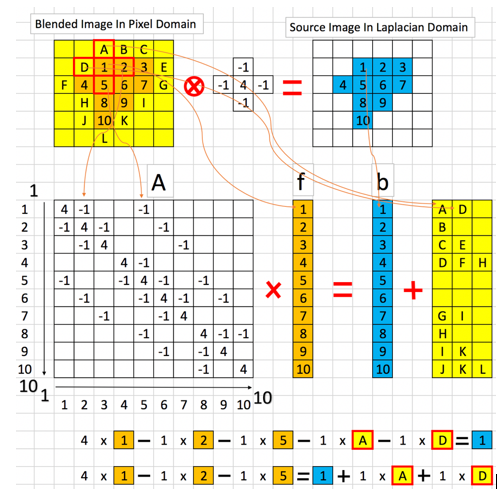

By writing the Laplacian operator as a matrix A and constructing the solution vector b, pixels in the reconstruction area can be obtained by solving equations.  

## Step 1. Index pixels in the blending area from 1 to N


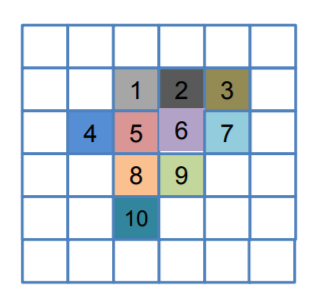

In [4]:
mask = np.zeros((6, 6))
mask[1, 2:5] = 1
mask[2, 1:5] = 1
mask[3, 2:4] = 1
mask[4, 2] = 1

In [5]:
mask

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [6]:
x, y = np.meshgrid(np.arange(mask.shape[1]), np.arange(mask.shape[0]))
target_x, target_y = x[mask > 0], y[mask > 0]
indexes = np.zeros_like(mask)
indexes[target_y, target_x] = np.arange(1, 11)

In [7]:
indexes

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  3.,  0.],
       [ 0.,  4.,  5.,  6.,  7.,  0.],
       [ 0.,  0.,  8.,  9.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

The mask uses coordinates in the source image, so mask position in the target image is (x+offsetX, y + offsetY).

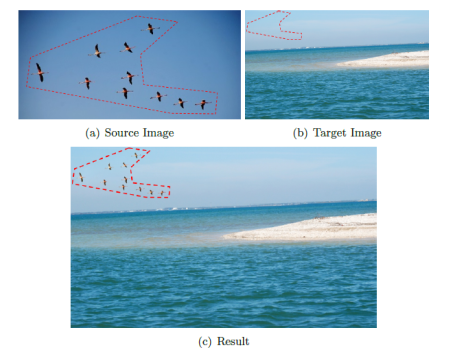

## Step 2. Construct coefficient matrix A


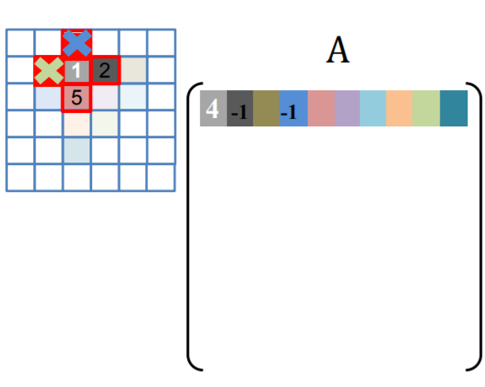

Filling in 4 is not hard. To fill in -1, we need to know the neighbor's index. Let's take left neighbor as an example:

In [ ]:
indexes

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  3.,  0.],
       [ 0.,  4.,  5.,  6.,  7.,  0.],
       [ 0.,  0.,  8.,  9.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [8]:
Y, X = np.nonzero(indexes) # get the coordinates of unknown pixels 
N = np.count_nonzero(indexes)
left = np.zeros(N, dtype=np.int32)
valid = X - 1 >= 0
left[valid] = indexes[Y[valid], (X - 1)[valid]] # assign the index of left neighthor of each known 

In [9]:
Y

array([1, 1, 1, 2, 2, 2, 2, 3, 3, 4])

In [10]:
X

array([2, 3, 4, 1, 2, 3, 4, 2, 3, 2])

In [11]:
np.nonzero(indexes)

(array([1, 1, 1, 2, 2, 2, 2, 3, 3, 4]), array([2, 3, 4, 1, 2, 3, 4, 2, 3, 2]))

In [ ]:
valid

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
left

array([0, 1, 2, 0, 4, 5, 6, 0, 8, 0], dtype=int32)

The result is a sparse matrix since there are at most 4 nonzero elements in each row. We will need to use sparse matrix provided by the scipy package, otherwise we might run out of memory. There are two ways to construct a sparse matrix:

In [ ]:
# method 1
row = np.array([0,0,1,2,2,2])
col = np.array([0,2,2,0,1,2])
data = np.array([1,2,3,4,5,6])
A_sparse = scipy.sparse.csr_matrix( (data,(row,col)), shape=(3,3) )
A_sparse.todense() # =toarray()
# todense convert the sparse matrix to dense matrix for display purpose, don't convert it in the actual code

matrix([[1, 0, 2],
        [0, 0, 3],
        [4, 5, 6]], dtype=int64)

In [ ]:
# method 2
A = np.array([[1, 0, 2],
            [0, 0, 3],
            [4, 5, 6]])
A_sparse = scipy.sparse.csr_matrix(A)
A_sparse.toarray()

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]], dtype=int64)

## Step 3. Construct solution vector b


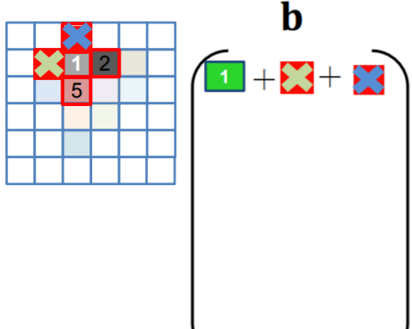

To construct solution vector, we compute the result of the source image after convolve with the Laplacian kernel. Then we add neighbors in the non blending area. 


In [ ]:
target_img = np.random.rand(6, 6)

In [ ]:
src_img = np.random.rand(6, 6)
laplacian = np.array([[0, -1, 0], 
                      [-1, 4, -1], 
                      [0, -1, 0]])
src_laplacian = scipy.signal.convolve(src_img, laplacian, 'same')

In [ ]:
# Laplacian part of b
offsetX, offsetY = 0, 0
Y_src, X_src = Y- offsetY, X - offsetX
laplacian = src_laplacian[Y_src, X_src]

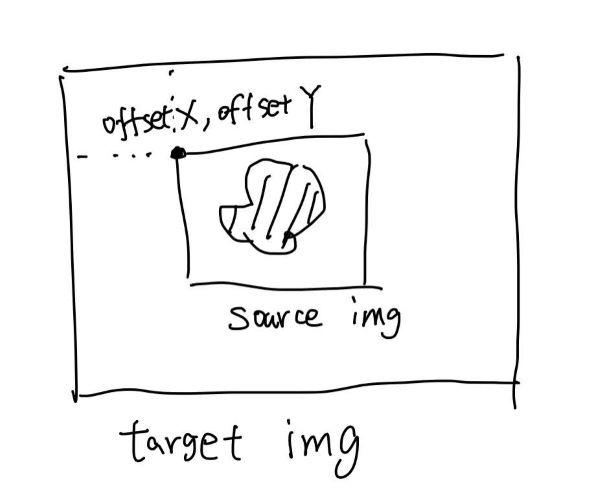

In [ ]:
# pixel part of b
Y, X = np.nonzero(indexes)
N = np.count_nonzero(indexes)
left_idx = np.zeros(N, dtype=np.int32)
left_val = np.zeros(N, dtype=np.float32)
valid = X - 1 >= 0
left_idx[valid] = indexes[Y[valid], (X - 1)[valid]] # same as before
good = np.logical_and(valid, left_idx == 0)
left_val[good] = target_img[Y[good], (X - 1)[good]]

In [ ]:
indexes

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  3.,  0.],
       [ 0.,  4.,  5.,  6.,  7.,  0.],
       [ 0.,  0.,  8.,  9.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
left_val

array([0.9529363 , 0.        , 0.        , 0.76872677, 0.        ,
       0.        , 0.        , 0.3251024 , 0.        , 0.1150201 ],
      dtype=float32)

In [ ]:
target_img

array([[0.52870658, 0.08060799, 0.97674278, 0.22822267, 0.60377814,
        0.29003306],
       [0.69116635, 0.95293632, 0.33993293, 0.8739261 , 0.22003749,
        0.15763489],
       [0.76872675, 0.38878905, 0.30715279, 0.36377556, 0.006073  ,
        0.22778134],
       [0.92000053, 0.32510239, 0.45312017, 0.74449547, 0.67981563,
        0.61037404],
       [0.963088  , 0.11502009, 0.542524  , 0.2493861 , 0.24047243,
        0.12162192],
       [0.78810918, 0.83089357, 0.14455393, 0.16279894, 0.47903511,
        0.76076006]])

In [ ]:
b = laplacian + left_val + right_val + up_val + down_val

## step 4. solve the equation and fill the pixel in the blending area 

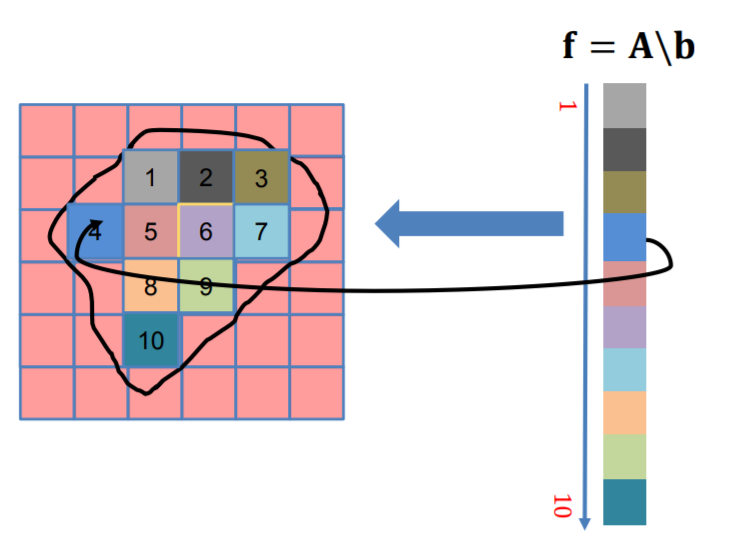


To solve equations with sparse matrix, use scipy.sparse.linalg.spsolve().

Constructing solution vector b for RGB individually. 

## Mixing Gradient

If the object of the source image has holes or is transparent, it is not a good idea to let it cover the target image.


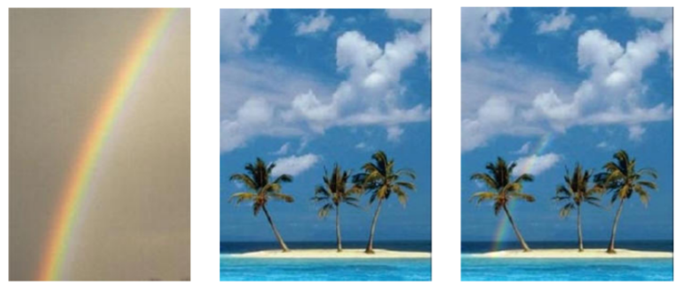

To do that, we modify the guided gradient field from 
$$ b_{Laplacian} = source\ image \times Laplacian\ kernel $$
to 

$$ b_{Laplacian} = \begin{cases} source\ image \times Laplacian\ kernel,\ if\ | source\ image \times Laplacian\ kernel| \geq |target\ image \times Laplacian\ kernel| \\ target\ image \times Laplacian\ kernel, otherwise \end{cases}$$


## Texture Flattening
If we change the guided gradient field to 
$$ b_{Laplacian} = \begin{cases} target\ image \times Laplacian\ kernel, if\ there\ is\ an\ edge \\ 0, else \end{cases} $$

Then we keep only the area with salient edge and remove other details.

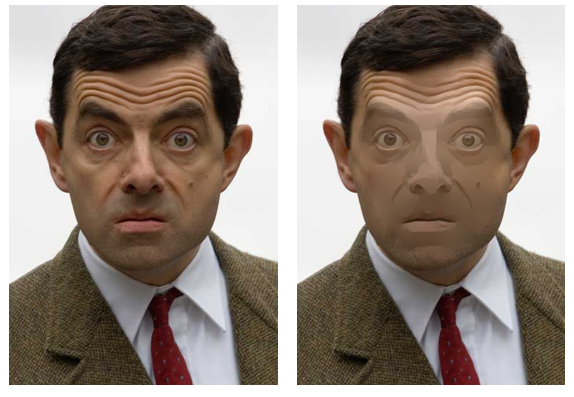

### Implementation tips:


This can be implemented by treating the Laplacian kernel as [-1, 1] in four directions.  

Let's consider one element in the solution vector that correpondes to (i, j) in the image. 

Then it has four neighbors (i-1, j), (i+1, j), (i, j-1), (i, j+1). 

In the Possion Image Editing part, the "Laplacian part" of the solution vector is  b = img[i, j] * 4 - img[i-1, j] - img[i+1, j] - img[i, j-1] - img[i, j+1]. 

We also view it as b = (img[i, j] - img[i-1, j]) + (img[i, j] - img[i+1, j]) + (img[i, j] - img[i, j-1]) + (img[i, j]- img[i, j+1]).

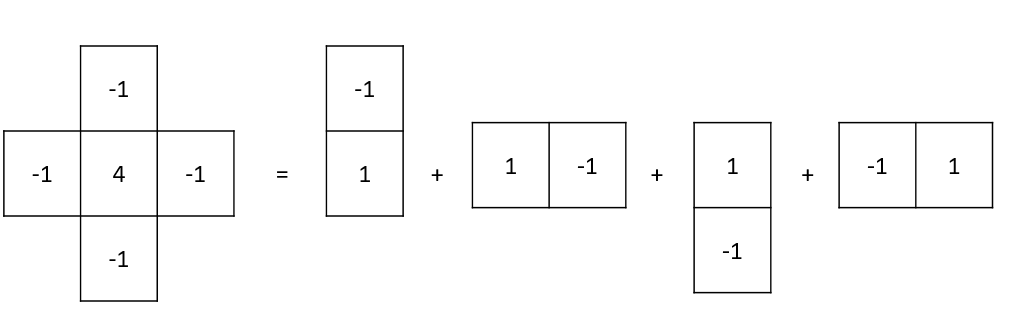

If edge_map[i, j] == 1 or edge_map[i-1, j] == 1, then (img[i, j] - img[i-1, j]) is part of the solution vector. Otherwise this direction should not be part of the solution vector.

The same logic applies to other directions. 